## Imports

In [59]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## Pure python function

In [60]:
def solve_2d_linearconv_pure(u, un, nt, dt, dx, dy, c):
    row, col = u.shape
    for n in range(nt):
        un[1:-1,1:-1] = u[1:-1,1:-1] # boundaries are are fixed to 1 (because the initial vector is ones())
        for i in range(1,row):
            for j in range(1,col):
                u[i,j]=un[i,j]-c*dt*((un[i,j]-un[i-1,j])/dx+(un[i,j]-un[i,j-1])/dy)    
    return 0

## Numba accelerator

In [61]:
@njit(fastmath=True)
def solve_2d_linearconv_numba(u, un, nt, dt, dx, dy, c):
    row, col = u.shape
    for n in range(nt):
        un[1:-1,1:-1] = u[1:-1,1:-1]  #boundaries are are fixed to 1 (because the initial vector is ones())
        for i in range(1,row-1):
            for j in range(1,col-1):
                u[i,j]=un[i,j]-c*dt*((un[i,j]-un[i-1,j])/dx+(un[i,j]-un[i,j-1])/dy)
    return 0

## Pyccel accelerator

In [62]:
def solve_2d_linearconv_pyccel(u:'float[:,:]', un:'float[:,:]', nt:'int', dt:'float', dx:'float', dy:'float', c:'float'):
    row, col = u.shape
    for n in range(nt):
        un[1:-1,1:-1] = u[1:-1,1:-1] #  boundaries are are fixed to 1 (because the initial vector is ones())
        for i in range(1,row):
            for j in range(1,col):
                u[i,j]=un[i,j]-c*dt*((un[i,j]-un[i-1,j])/dx+(un[i,j]-un[i,j-1])/dy)
    return 0

## Inputs

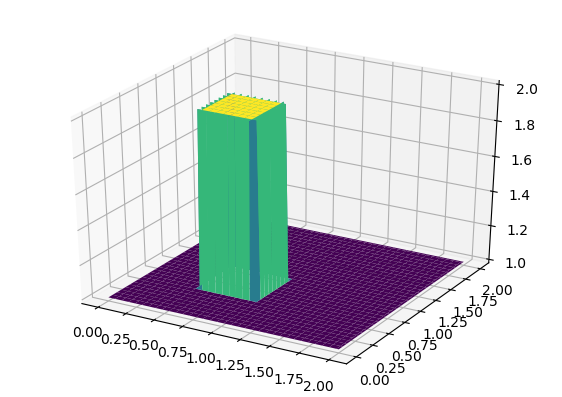

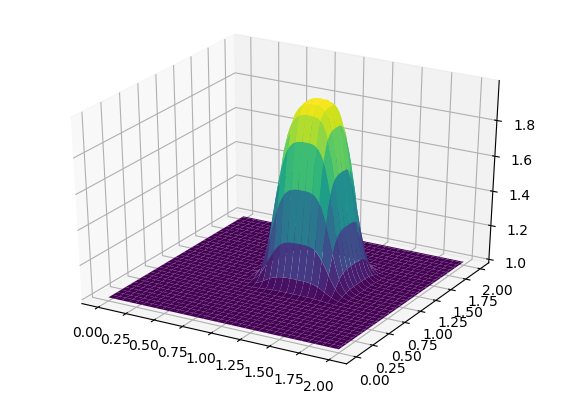

In [63]:
###variable declarations
nx = 101
ny = 101
nt = 100
c = 1.
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .2
dt = sigma * dx

x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u0 = np.ones((ny, nx)) ##create a 1xn vector of 1's
u0[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
u = u0.copy()
un = np.ones((ny, nx)) 

solve_2d_linearconv_pure(u, un, nt, dt, dx, dy, c)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')                      
X, Y = np.meshgrid(x, y)                            
surf = ax.plot_surface(X, Y, u0[:], cmap=cm.viridis)

fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')
surf2 = ax.plot_surface(X, Y, u[:], cmap=cm.viridis)

## Call Funtions

### Pure function

In [52]:
%timeit solve_2d_linearconv_pure(u, un, nt, dt, dx, dy, c)

1.85 s ± 29.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with numba accelerator

In [53]:
%timeit solve_2d_linearconv_numba(u, un, nt, dt, dx, dy, c)

1.29 ms ± 88.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with pyccel accelerator

In [54]:
solve_2d_linearconv_f90 = epyccel(solve_2d_linearconv_pyccel)

In [55]:
%timeit solve_2d_linearconv_f90(u, un, nt, dt, dx, dy, c)

3.41 ms ± 23.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
